# Classifying with k-Nearest Neighbors

For every point in our dataset:

- calculate the distance between inX and the current point
- sort the distances in increasing order
- take k items with lowest distances to inX
- find the majority class among these items
- return the majority class as our prediction for the class of inX

In [13]:
from numpy import *
import operator
from os import listdir

In [14]:
def createDataSet():
    group = array([[1.0,1.1],[1.0,1.0],[0,0],[0,0.1]])
    labels = ['A','A','B','B']
    return group, labels

In [15]:
def classify0(inX, dataSet, labels, k):
    dataSetSize = dataSet.shape[0]                        # 4
    
    #distance calculation
    diffMat = tile(inX, (dataSetSize,1)) - dataSet
    sqDiffMat = diffMat**2
    sqDistances = sqDiffMat.sum(axis=1)
    distances = sqDistances**0.5
    sortedDistIndicies = distances.argsort()
    
    # voting for lowest k distances
    classCount={}          
    for i in range(k):
        voteIlabel = labels[sortedDistIndicies[i]]
        classCount[voteIlabel] = classCount.get(voteIlabel,0) + 1
    
    # classCount = {'B': 2, 'A': 1}
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

In [16]:
groups, labels = createDataSet()
classify0([0, 0], groups, labels, 3)

'B'

## Improving matches from a dating site with kNN

Ну, представим, что есть девушка, которая на основе трех каких-то параметров поделила всех своих ухажеров на три категории:  те, которые ей не нравятся, те которые нравятся в малых дозах, и те, с которыми вообще все в порядке.  Теперь на основе этих трех параметров для каждого нового парня она хочет предсказывать, как у нее с ним сложатся отношения.

In [17]:
def file2matrix(filename):
    fr = open(filename)
    numberOfLines = len(fr.readlines())         #get the number of lines in the file
    returnMat = zeros((numberOfLines,3))        #prepare matrix to return
    classLabelVector = []                       #prepare labels return   
    fr = open(filename)
    index = 0
    for line in fr.readlines():
        line = line.strip()
        listFromLine = line.split('\t')
        returnMat[index,:] = listFromLine[0:3]
        classLabelVector.append(listFromLine[-1])
        index += 1
    return returnMat,classLabelVector

In [18]:
datingDataMat, datingLabels = file2matrix('data\datingTestSet.txt')

In [19]:
datingDataMat

array([[4.0920000e+04, 8.3269760e+00, 9.5395200e-01],
       [1.4488000e+04, 7.1534690e+00, 1.6739040e+00],
       [2.6052000e+04, 1.4418710e+00, 8.0512400e-01],
       ...,
       [2.6575000e+04, 1.0650102e+01, 8.6662700e-01],
       [4.8111000e+04, 9.1345280e+00, 7.2804500e-01],
       [4.3757000e+04, 7.8826010e+00, 1.3324460e+00]])

In [20]:
datingLabels[0:20]

['largeDoses',
 'smallDoses',
 'didntLike',
 'didntLike',
 'didntLike',
 'didntLike',
 'largeDoses',
 'largeDoses',
 'didntLike',
 'largeDoses',
 'didntLike',
 'didntLike',
 'smallDoses',
 'didntLike',
 'didntLike',
 'didntLike',
 'didntLike',
 'didntLike',
 'smallDoses',
 'largeDoses']

Вообще, прежде чем писать алгоритм классификации бывает полезно поиграться с данными, визуализировать их и попробовать найти зависимость результата от какой-то комбинации параметров.

Так если мы построим распределение точек на плоскости в зависимости от 2-х из 3-х параметров, то мы увидим, что они будут расположены тремя группами, границы которых совпадают с оценкой данной девушкой.

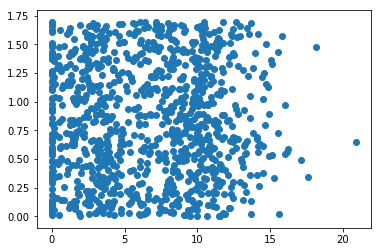

In [42]:
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(datingDataMat[:, 1], datingDataMat[:, 2])
plt.show()

У нас может так сложиться, что один из параметров будет принимать маленькие значения 0..1, а другой большие 1000..100000. Чтобы второй параметр не забивал первый (ну, они же оба входят в формулу расстояния), мы эти параметры нормализуем - приведем к виду 0..1:

In [22]:
def autoNorm(dataSet):
    minVals = dataSet.min(0)
    maxVals = dataSet.max(0)
    ranges = maxVals - minVals
    normDataSet = zeros(shape(dataSet))
    m = dataSet.shape[0]
    normDataSet = dataSet - tile(minVals, (m,1))
    normDataSet = normDataSet/tile(ranges, (m,1))   #element wise divide
    return normDataSet, ranges, minVals

In [23]:
normMat, ranges, minVals = autoNorm(datingDataMat)
normMat

array([[0.44832535, 0.39805139, 0.56233353],
       [0.15873259, 0.34195467, 0.98724416],
       [0.28542943, 0.06892523, 0.47449629],
       ...,
       [0.29115949, 0.50910294, 0.51079493],
       [0.52711097, 0.43665451, 0.4290048 ],
       [0.47940793, 0.3768091 , 0.78571804]])

In [24]:
def datingClassTest():
    hoRatio = 0.50      #hold out 10%
    datingDataMat,datingLabels = file2matrix('data\datingTestSet2.txt')       #load data setfrom file
    normMat, ranges, minVals = autoNorm(datingDataMat)
    m = normMat.shape[0]
    numTestVecs = int(m*hoRatio)
    errorCount = 0.0
    for i in range(numTestVecs):
        classifierResult = classify0(normMat[i,:],normMat[numTestVecs:m,:],datingLabels[numTestVecs:m],3)
        print(f"the classifier came back with: {classifierResult}, the real answer is: {datingLabels[i]}")
        if (classifierResult != datingLabels[i]): errorCount += 1.0
    print(f"the total error rate is: {errorCount/float(numTestVecs)}")
    print(errorCount)

In [25]:
datingClassTest()

the classifier came back with: 3, the real answer is: 3
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answe

the classifier came back with: 1, the real answer is: 1
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 2, the real answer is: 1
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 2, the real answer is: 2
the total error rate is: 0.066
33.0


In [40]:
def classifyPerson():
    resultList = ['not at all', 'in small doses', 'in large doses']
    percentTats = float(10)
    ffMiles = float(20)
    iceCream = float(30)
    datingDataMat, datingLabels = file2matrix('data\datingTestSet.txt')
    normMat, ranges, minValues = autoNorm(datingDataMat)
    inArr = array([ffMiles, percentTats, iceCream])
    classifierResult = classify0((inArr - minVals)/ranges, normMat, datingLabels, 3)
    print(classifierResult)

In [41]:
classifyPerson()

smallDoses
